In [115]:
#get dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import keras
import tensorflow as tf
import os

from keras import backend as K

from preprocessing import scale_data10

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score


In [116]:
#Reproducability
seed = 42

In [117]:
#Load data

dataset = np.load('../data/dataset.npz',)
X, y = dataset['X'], dataset['y']



#split data
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,train_size=.7,random_state=seed)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test, train_size=.5, random_state=seed)

print(X_train.shape,y_train.shape,X_val.shape)

from preprocessing import generate_balanced_data
#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)
#print(X_train_aug.shape)

(6883, 400) (6883,) (1475, 400)


# Make PipeLine


In [118]:
#define pipeline: (CAN MBY USE SCALE10 instead? idunno)
pipeline_SVM = Pipeline([
    ('scale', StandardScaler()),
    ('PCA', PCA()),
    ('SVC', SVC())
])

In [119]:
#Fit pipeline
pipeline_SVM.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()), ('PCA', PCA()), ('SVC', SVC())])

In [120]:
#Define grid
hparams = {
    'PCA__n_components' : [400,200,100,50],
    'SVC__C' : [1e2, 1e1, 1e0],
    'SVC__gamma' : [0.0001,0.001],
    'SVC__degree' : [2,4,6],
    'SVC__kernel' : ['rbf','poly']
}

In [121]:
#grid search w/ CV to find params:
gscv = GridSearchCV(
    pipeline_SVM,
    param_grid=hparams,
    n_jobs=-1,
    verbose=2
    )

gscv.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.0001, SVC__kernel=rbf; total time=   6.9s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.0001, SVC__kernel=rbf; total time=   6.9s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.0001, SVC__kernel=rbf; total time=   7.0s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.0001, SVC__kernel=rbf; total time=   7.0s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.0001, SVC__kernel=rbf; total time=   7.2s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.001, SVC__kernel=rbf; total time=   8.1s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.001, SVC__kernel=rbf; total time=   8.1s
[CV] END PCA__n_components=400, SVC__C=100.0, SVC__degree=2, SVC__gamma=0.001, SVC__kernel=rbf; total time=   8.0s
[CV] END PCA

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('PCA', PCA()), ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'PCA__n_components': [400, 200, 100, 50],
                         'SVC__C': [100.0, 10.0, 1.0], 'SVC__degree': [2, 4, 6],
                         'SVC__gamma': [0.0001, 0.001],
                         'SVC__kernel': ['rbf', 'poly']},
             verbose=2)

In [128]:
#Find best results, and define model

print(f"Best score: {gscv.best_score_}, \nusing parameters: {gscv.best_params_}")
print(f"For validation data:\n")
svm_model = gscv.best_estimator_

Best score: 0.9200938170272416, 
using parameters: {'PCA__n_components': 200, 'SVC__C': 100.0, 'SVC__degree': 2, 'SVC__gamma': 0.001, 'SVC__kernel': 'poly'}
For validation data:



In [129]:
y_pred_1 = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_1)
print(f"accuracy_score (on val): {accuracy:.2f}")

accuracy_score (on val): 0.92


------------------------------ SVM CMatrix ------------------------------


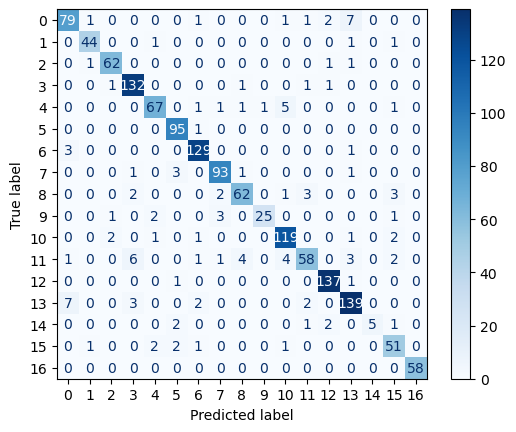

accuracy_score (on val): 0.92


In [124]:
#visual of where my model messes up
y_pred = svm_model.predict(X_val)

print(30*"-","SVM CMatrix",30*"-")
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=cm.Blues)
plt.show()

score = accuracy_score(y_val,y_pred)
print(f"accuracy_score (on val): {score:.2f}")

In [193]:
def get_label(l):
    if l <10:
        return l
    return names[l]

names = {
    10 : "A",
    11 : "B",
    12 : "C",
    13 : "D",
    14 : "E",
    15 : "F",
    16 : "G"

}

(1475, 400)
1475
(120, 400)


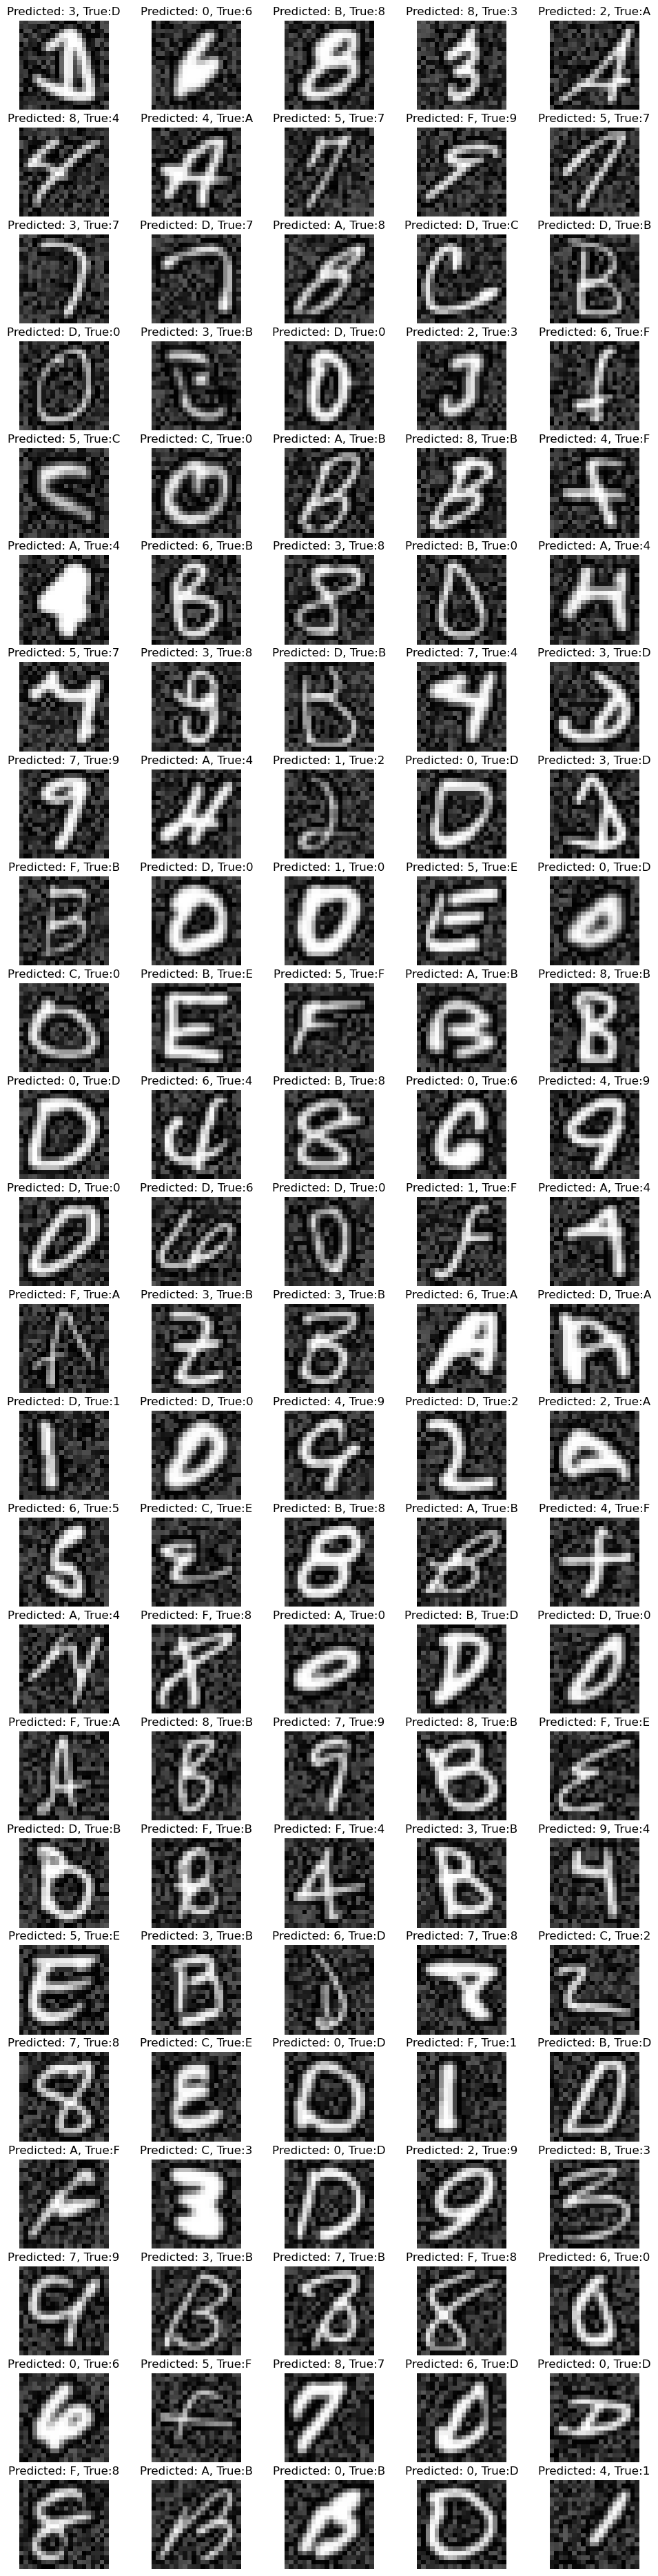

In [194]:
#visual of f-ups
fig = plt.figure(figsize=(12, 48))
wrongPred = X_val[y_pred != y_val]
print(X_val.shape)
print(len(y_pred))
print(wrongPred.shape)
cols = 5
rows = 24
count = 1

for idx in range(len(y_pred)):
    if(y_pred[idx] != y_val[idx]):
        fig.add_subplot(rows, cols, count)
        plt.axis('off') 
        #pred_lab = 
        plt.title(f"Predicted: {get_label(y_pred[idx])}, True:{get_label(y_val[idx])}") 
        plt.imshow(X_val[idx].reshape(20,20), vmin=0, vmax=255, cmap="gray")
        #print("Predicted",y_pred[idx], " vs true value:",y_val[idx])
        #print("idx = ", idx,". count = ", count)
        #fig.set_label(f'Predicted: {y_pred[idx]}, True:{y_val[idx]}')
        count+=1
    

plt.show()
#plt.imshow(X[k].reshape(20,20), vmin=0, vmax=255, cmap="gray")


# Bagging

In [125]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline_SVM = Pipeline([
    ('scale', StandardScaler()),
    ('PCA', PCA(n_components=200)),
    ('SVC', SVC())
])

pipeline_DT = Pipeline([
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=seed))
])


bag_model = BaggingClassifier(pipeline_SVM,
                            n_estimators=200,
                            random_state=seed,
                            verbose=2,
                            n_jobs=-1,

                            )
bag_model.fit(X_train,y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...Building estimator 1 of 25 for this parallel run (total 200)...

Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished


BaggingClassifier(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                            ('PCA', PCA(n_components=200)),
                                            ('SVC', SVC())]),
                  n_estimators=200, n_jobs=-1, random_state=42, verbose=2)

In [126]:
print(y_train.shape)
print(y_val.shape)

y_pred_11 = bag_model.predict(X_val)

score = accuracy_score(y_val,y_pred_11)
print(f"accuracy_score (on val): {score:.2f}")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


(6883,)
(1475,)


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   45.4s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   50.8s finished


accuracy_score (on val): 0.90
